#import

In [1]:
import re
import string
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

#Data

In [4]:
df = pd.read_csv('amazon_products.csv')
df.head(5)

,DATE,RATING,REVIEW_TITLE,DESCRIPTION1,DESCRIPTION2,LINK
0,2020-02-26 0:00:00,4,"Really sweet, more coconut than almond flavor",I got this for my two oldest girls who are ath...,"They felt the flavor balance was off, that it ...",https://www.amazon.com/gp/customer-reviews/RZY...
1,2020-08-14 0:00:00,5,kids loved them,bought a few for my kids. I didn't taste them ...,I didn't taste them but they said they were good.,https://www.amazon.com/gp/customer-reviews/R21...
2,2020-04-27 0:00:00,5,Absolutely the best.,The is the best buckwheat flour I have ever ha...,The is the best buckwheat flour I have ever had.,https://www.amazon.com/gp/customer-reviews/R1X...
3,2020-02-10 0:00:00,5,Scrumptious at Tea Time,Danger: these rolled cookies are so delicious!...,Scrumptious at Tea Time.,https://www.amazon.com/gp/customer-reviews/RZU...
4,2020-12-20 0:00:00,5,DELICIOUS and ADDICCTIVE,I could not stop eating these. Love both the p...,Love both the pancake and butter and salt flav...,https://www.amazon.com/gp/customer-reviews/R10...


In [5]:
def combine_desc(row):
  if row["DESCRIPTION1"].strip().lower() == row["DESCRIPTION2"].strip().lower():
    return f'{row["REVIEW_TITLE"]} {row["DESCRIPTION1"]}' 
  else:
    return f'{row["REVIEW_TITLE"]} {row["DESCRIPTION1"]} {row["DESCRIPTION2"]}' 
df['desc'] = df.apply (lambda row: combine_desc(row), axis=1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


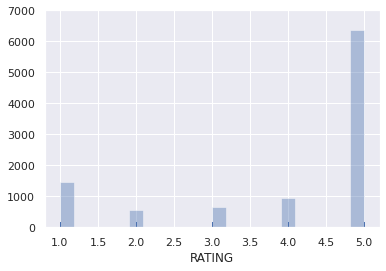

In [6]:
sns.set()
sns.distplot(df['RATING'], kde=False, rug=True)

In [7]:
def label2sentiment(label):
    if label >= 4:
        return "Positive"
    elif label == 3:
        return "Natural"
    else:
        return "Negative"

df['sentiment'] = df['RATING'].apply(lambda label: label2sentiment(label))

In [8]:
df['sentiment'].value_counts()

Positive    7315
Negative    2026
Natural      659
Name: sentiment, dtype: int64

In [9]:
def sentiment2label(sentiment):
    if sentiment == "Positive":
        return 1
    elif sentiment == "Natural":
        return 2
    else:
        return 0
df["label"] = df["sentiment"].apply(sentiment2label)

# preproccessor

In [10]:
class preproccessor:
  def __init__(self,df):
    self.columns = ['sentiment','label','desc']
    if not all(column in df.columns for column in self.columns):
      print(f'Not all required fields are available: {self.columns}')
      return
    self.df = df
  
  # This function will be our all-in-one noise removal function
  def __remove_noise(self,tokens):
    chars = re.escape(string.punctuation)
    cleaned_tokens = []
    for token, tag in pos_tag(tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub(r'['+chars+']', '',token)
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        cleaned_token = token.lower()
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

  def clear_data(self):
    self.df['word_tokenize'] = self.df['desc'].apply(lambda x: word_tokenize(x))
    self.df['clean_desc'] = self.df['word_tokenize'].apply(lambda x: self.__remove_noise(x))
    self.df["len"] = self.df['clean_desc'].apply(lambda x : len(x))
    print(f'Data Removing: {Counter(self.df[self.df["len"]<=3]["sentiment"])}')
    self.df = self.df[self.df["len"]>3]
    self.df = self.df.reset_index()
    return self.df
  

# Clear Data

In [11]:
p = preproccessor(df.copy())
df = p.clear_data()

Data Removing: Counter({'Positive': 111, 'Negative': 10, 'Natural': 6})


In [12]:
df.head(3)

,index,DATE,RATING,REVIEW_TITLE,DESCRIPTION1,DESCRIPTION2,LINK,desc,sentiment,label,word_tokenize,clean_desc,len
0,0,2020-02-26 0:00:00,4,"Really sweet, more coconut than almond flavor",I got this for my two oldest girls who are ath...,"They felt the flavor balance was off, that it ...",https://www.amazon.com/gp/customer-reviews/RZY...,"Really sweet, more coconut than almond flavor ...",Positive,1,"[Really, sweet, ,, more, coconut, than, almond...","[really, sweet, coconut, almond, flavor, get, ...",89
1,1,2020-08-14 0:00:00,5,kids loved them,bought a few for my kids. I didn't taste them ...,I didn't taste them but they said they were good.,https://www.amazon.com/gp/customer-reviews/R21...,kids loved them bought a few for my kids. I di...,Positive,1,"[kids, loved, them, bought, a, few, for, my, k...","[kid, love, buy, kid, taste, say, good, taste,...",10
2,2,2020-04-27 0:00:00,5,Absolutely the best.,The is the best buckwheat flour I have ever ha...,The is the best buckwheat flour I have ever had.,https://www.amazon.com/gp/customer-reviews/R1X...,Absolutely the best. The is the best buckwheat...,Positive,1,"[Absolutely, the, best, ., The, is, the, best,...","[absolutely, best, best, buckwheat, flour, eve...",13


##Visualizing the Data

Word Clouds are one of the best visualizations for words frequencies in text documents.
Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

In [ ]:
# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def data_visualization(df):
  positive_words = df[df['label']== 1]['clean_desc']
  positive_words  = [word for sentence in positive_words for word in sentence] 

  negative_words = df[df['label']== 0]['clean_desc']
  negative_words  = [word for sentence in negative_words for word in sentence] 

  netural_words = df[df['label']== 2]['clean_desc']
  netural_words  = [word for sentence in netural_words for word in sentence] 

  print("Positive words")
  wordcloud_draw(positive_words, 'white')
  print("Negative words")
  wordcloud_draw(negative_words)  

  print("Netural words")
  wordcloud_draw(netural_words)  

Positive words


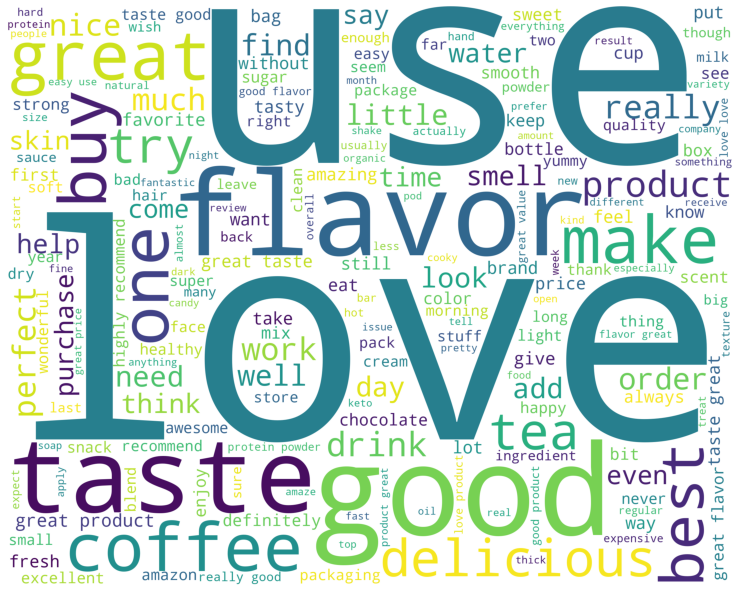

Negative words


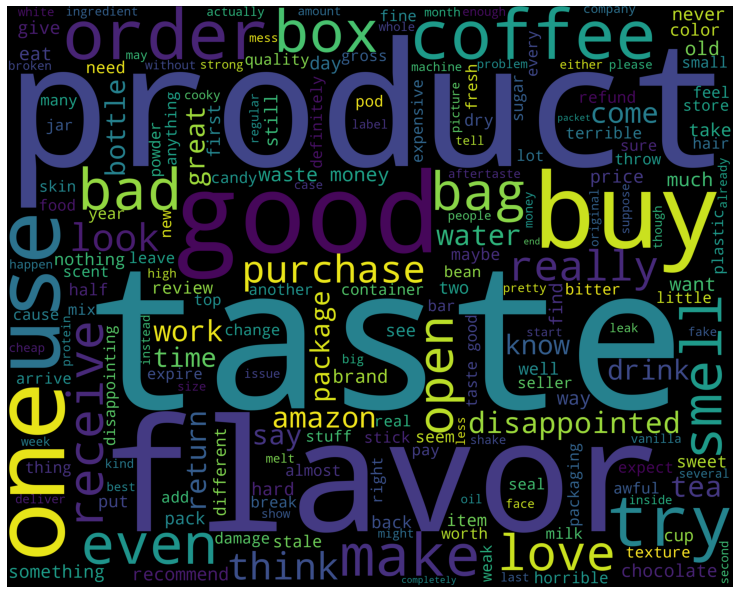

Netural words


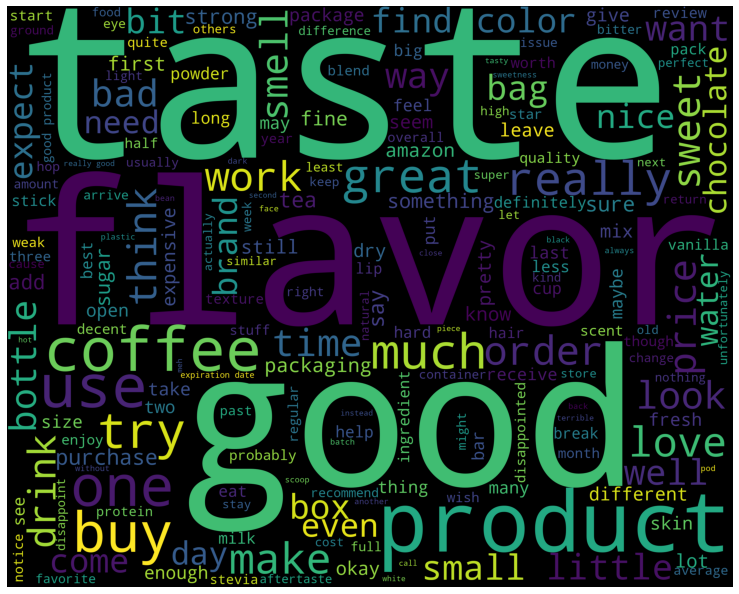

In [ ]:
data_visualization(df)

# model

## Feture - Word Embedding

Read Glove Embedding

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [14]:
class word_embedding_provider:

  def __init__(self):
    self.unks = []

  def read_glove_vecs(self,glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split(' ')
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

  # This function will act as a "last resort" in order to try and find the word
  # in the words embedding layer. It will basically eliminate contiguously occuring
  # instances of a similar character
  def __cleared(self,word):
      res = ""
      prev = None
      for char in word:
          if char == prev: continue
          prev = char
          res += char
      return res

  def __sentence_to_indices(self,sentence_words, word_to_index, max_len, i):
      global X
      for j, w in enumerate(sentence_words):
          try:
              index = word_to_index[w]
          except:
              w = self.__cleared(w)
              try:
                  index = word_to_index[w]
              except:
                  index = word_to_index['unk']
                  self.unks.append(w)
          self.X[i, j] = index

  def get_glove_word_embedding(self, word_to_index, index_to_word, word_to_vec_map, clean_desc, max_len):
    self.X = np.zeros((len(clean_desc), max_len)) # Data Padding
    for i, tokens in enumerate(clean_desc):
        self.__sentence_to_indices(tokens, word_to_index, max_len, i)
    return self.X

In [15]:
embedding_provider = word_embedding_provider()
word_to_index, index_to_word, word_to_vec_map = embedding_provider.read_glove_vecs('glove.6B.50d.txt')

In [16]:
max_len = max(df["len"])
print('max_len:', max_len)
X = embedding_provider.get_glove_word_embedding(word_to_index, index_to_word, word_to_vec_map,df['clean_desc'] ,max_len)
Y = df['label']

max_len: 131


In [17]:
from collections import Counter
Counter(embedding_provider.unks).most_common(10)

[('coky', 217),
 ('kcups', 72),
 ('smothy', 53),
 ('preworkout', 50),
 ('kcup', 39),
 ('overprice', 36),
 ('covid', 21),
 ('delish', 21),
 ('recomend', 19),
 ('glutenfre', 18)]

##Split data and Imbalanced Dataset

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

overload data -SMOTE

In [23]:
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
# summarize distribution
counter = Counter(Y_train)
for k,v in counter.items():
	per = v / len(Y_train) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=5763 (33.333%)
Class=0, n=5763 (33.333%)
Class=2, n=5763 (33.333%)


In [24]:
Y_train = tf.keras.utils.to_categorical(Y_train, 3)
Y_test = tf.keras.utils.to_categorical(Y_test, 3)

In [25]:
print(f'train size: {len(X_train)}')
print(f'test size: {len(X_test)}')

train size: 17289
test size: 1975


## Building the Model

In [26]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [27]:
class biLstmModel():
  def __init__(self,word_to_vec_map, word_to_index, max_len):
    # Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
    # that finally feed into a softmax layer with 3 units
    self.model = Sequential()
    self.model.add(self.__pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
    self.model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    self.model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
    self.model.add(Dropout(rate=0.5))
    self.model.add(Dense(units=3, activation='softmax'))
    self.model.summary()

    self.METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name="auc")]

    self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=self.METRICS)
    self.custom_early_stopping = EarlyStopping(
    monitor='val_auc', 
    patience=4, 
    min_delta=0.001, 
    mode='max')
  
  def fit(self, X_train, Y_train, validation_split = 0.25, epochs = 20, batch_size = 512):
    # Setting a batch size of 64 , 20 epochs, 0.2 validation
    self.model.fit(X_train, Y_train, validation_split=validation_split, epochs = epochs, batch_size = batch_size, shuffle=True, callbacks=[self.custom_early_stopping])
  
  def evaluate(self,X_test, Y_test):
    return self.model.evaluate(X_test, Y_test)

  def predict(self,X_test):
    return self.model.predict(X_test)

  def plot_acc_loss(self):
    history = self.model.history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Defining a function that will initialize and populate our embedding layer

  def __pretrained_embedding_layer(self,word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer




In [28]:
biLstm_Model = biLstmModel(word_to_vec_map, word_to_index, max_len)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 131, 50)           20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 131, 256)         183296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 20,578,357
Trainable params: 578,307
Non-t

## FIT MODEL

In [ ]:
biLstm_Model.fit(X_train, Y_train)

Epoch 1/20
 8/26 [========>.....................] - ETA: 1:38 - loss: 0.7513 - accuracy: 0.8092 - precision: 0.7552 - recall: 0.6326 - auc: 0.8437

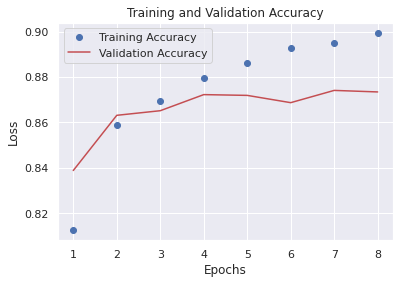

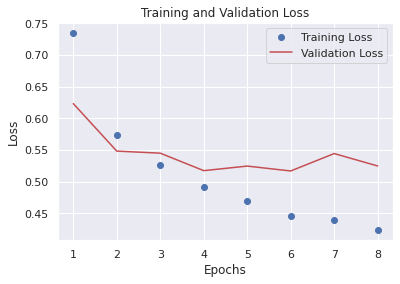

In [ ]:
# Plotting the obtained training and validation loss and accuracy progressions.
biLstm_Model.plot_acc_loss()

#Evaluate the Model

In [ ]:
score = biLstm_Model.evaluate(X_test, Y_test) 
print("Testing Accuracy(%): ", score[1]*100)

62/62 [==============================] - 4s 60ms/step - loss: 0.4979 - accuracy: 0.8805 - precision: 0.8573 - recall: 0.7696 - auc: 0.9361
Testing Accuracy(%):  88.05063366889954


In [ ]:
y_pred = biLstm_Model.predict(X_test)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in Y_test])

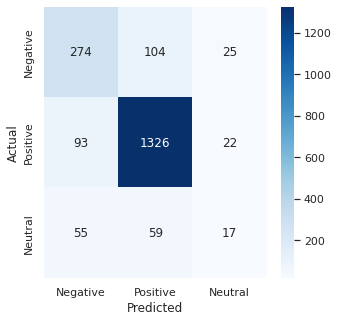

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=['Negative', 'Positive','Neutral']
plt.figure(figsize=(5,5))
sns.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()